In [1]:
gamma = 0.45
%run ./earthquake-2015-base.ipynb

Using gamma = 0.45


,is_new_construction_count,is_new_construction,isnt_new_construction_count,isnt_new_construction
damage_grade,,,,
Grade 1,46017,19.802649,27602,5.362256
Grade 2,37465,16.122438,46144,8.964421
Grade 3,39944,17.189235,92224,17.916409
Grade 4,42908,18.464743,138559,26.917936
Grade 5,66044,28.420935,210217,40.838977


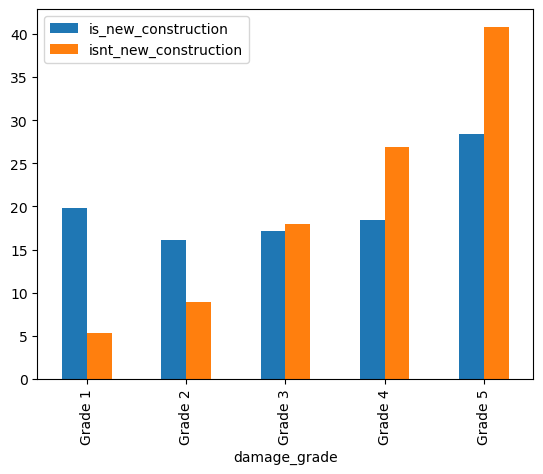

In [2]:
# Damage grade for new vs old construction
damage_grade_new_construction = histogram(households, 'damage_grade', 'new_construction')
histogram_plot(damage_grade_new_construction, 'new_construction')
damage_grade_new_construction

,is_new_construction_p_count,is_new_construction_p,isnt_new_construction_p_count,isnt_new_construction_p
damage_grade_p,,,,
Grade 1,43950,19.723291,34349,6.551489
Grade 2,36438,16.352156,51228,9.770872
Grade 3,38763,17.395538,94665,18.055744
Grade 4,41477,18.613491,138029,26.326691
Grade 5,62205,27.915524,206022,39.295203


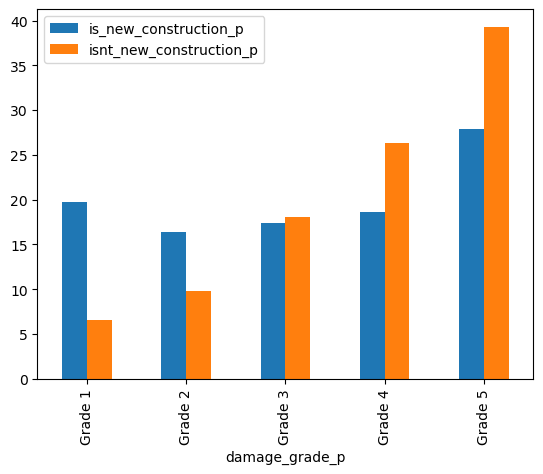

In [3]:
# Damage grade for new vs old construction - perturbed
damage_grade_new_construction_p = histogram(households, 'damage_grade_p', 'new_construction_p')
histogram_plot(damage_grade_new_construction_p, 'new_construction_p')
damage_grade_new_construction_p

,is_poverty_count,is_poverty,isnt_poverty_count,isnt_poverty
damage_grade,,,,
Grade 1,10990,8.349731,62629,10.175255
Grade 2,15449,11.737489,68160,11.073870
Grade 3,26632,20.233853,105536,17.146301
Grade 4,34647,26.323307,146820,23.853661
Grade 5,43903,33.355620,232358,37.750913


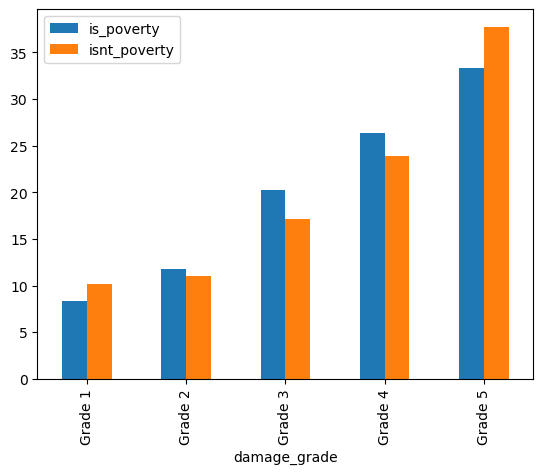

In [4]:
# Intensity of building damage by household, poverty
damage_grade = histogram(households, 'damage_grade', 'poverty')
histogram_plot(damage_grade, 'poverty')
damage_grade

,is_poverty_p_count,is_poverty_p,isnt_poverty_p_count,isnt_poverty_p
damage_grade_p,,,,
Grade 1,13801,9.242257,64498,10.789209
Grade 2,18083,12.109828,69583,11.639827
Grade 3,29576,19.806462,103852,17.372336
Grade 4,38249,25.614599,141257,23.629435
Grade 5,49616,33.226854,218611,36.569193


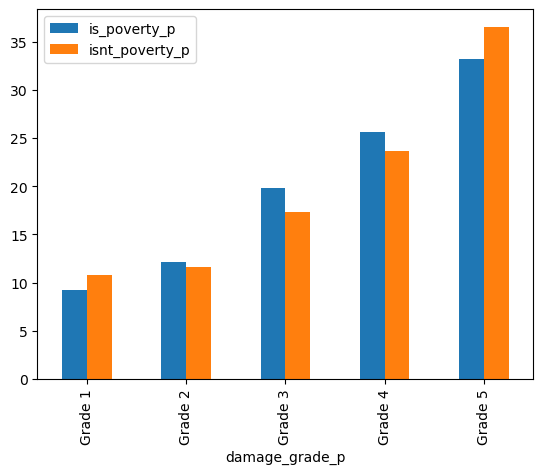

In [5]:
# Intensity of building damage by household, poverty - perturbed
damage_grade_p = histogram(households, 'damage_grade_p', 'poverty_p')
histogram_plot(damage_grade_p, 'poverty_p')
damage_grade_p

,is_poverty_count,is_poverty,isnt_poverty_count,isnt_poverty
condition_post_eq,,,,
Covered by landslide,40,0.030390,292,0.047440
Damaged-Not used,34531,26.234577,159348,25.888649
Damaged-Repaired and used,23383,17.764997,83613,13.584278
Damaged-Rubble Clear-New building built,6218,4.724062,26641,4.328260
Damaged-Rubble clear,15357,11.667325,87531,14.220821
Damaged-Rubble unclear,19374,14.719200,106454,17.295167
Damaged-Used in risk,25089,19.061113,102853,16.710126
Not damaged,7632,5.798335,48781,7.925259


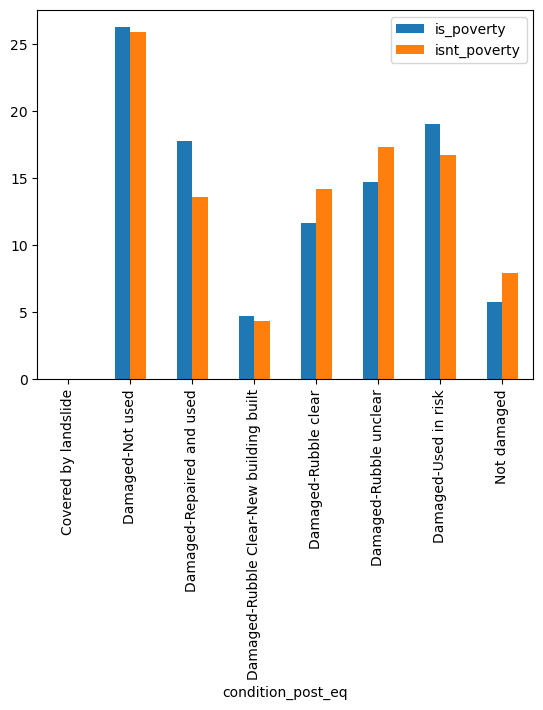

In [6]:
# Condition of building after earthquake by household, poverty
condition_post_eq = histogram(households, 'condition_post_eq', 'poverty')
histogram_plot(condition_post_eq, 'poverty')
condition_post_eq

,is_poverty_p_count,is_poverty_p,isnt_poverty_p_count,isnt_poverty_p
condition_post_eq_p,,,,
Covered by landslide,1130,0.756729,4467,0.747227
Damaged-Not used,37956,25.418042,150025,25.095766
Damaged-Repaired and used,25253,16.911208,81044,13.556816
Damaged-Rubble Clear-New building built,7562,5.064054,28848,4.825613
Damaged-Rubble clear,18074,12.103638,84248,14.092772
Damaged-Rubble unclear,22383,14.989252,101585,16.992857
Damaged-Used in risk,27411,18.356359,98514,16.479149
Not damaged,9558,6.400718,49079,8.209799


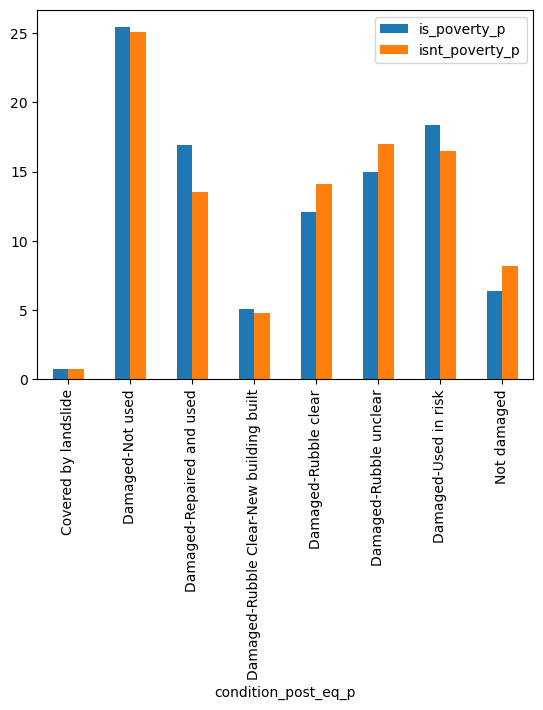

In [7]:
# Condition of building after earthquake by household, poverty - perturbed
condition_post_eq_p = histogram(households, 'condition_post_eq_p', 'poverty_p')
histogram_plot(condition_post_eq_p, 'poverty_p')
condition_post_eq_p

,is_poverty_count,is_poverty,isnt_poverty_count,isnt_poverty
condition_post_eq,,,,
Covered by landslide,4,0.013395,85,0.040568
Damaged-Not used,7213,24.154444,49348,23.552433
Damaged-Repaired and used,6000,20.092425,31821,15.187282
Damaged-Rubble Clear-New building built,1204,4.031880,8399,4.008610
Damaged-Rubble clear,2946,9.865381,24972,11.918444
Damaged-Rubble unclear,3727,12.480745,31657,15.109009
Damaged-Used in risk,6381,21.368294,39990,19.086119
Not damaged,2387,7.993436,23252,11.097535


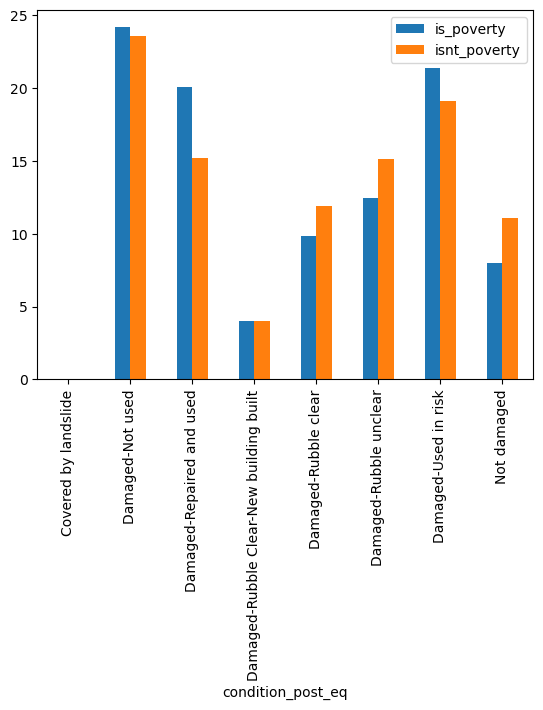

In [8]:
# Condition of building after earthquake by household, poverty (female head of household)
condition_post_eq_f = histogram(households[households['gender_household_head'] == 'Female'], 'condition_post_eq', 'poverty')
histogram_plot(condition_post_eq_f, 'poverty')
condition_post_eq_f

,is_poverty_p_count,is_poverty_p,isnt_poverty_p_count,isnt_poverty_p
condition_post_eq_p,,,,
Covered by landslide,294,0.729583,1607,0.756631
Damaged-Not used,9563,23.731295,49305,23.214479
Damaged-Repaired and used,7405,18.376058,31517,14.839281
Damaged-Rubble Clear-New building built,1892,4.695139,9657,4.546846
Damaged-Rubble clear,4355,10.807256,25913,12.200726
Damaged-Rubble unclear,5351,13.278904,32507,15.305407
Damaged-Used in risk,8120,20.150383,39010,18.367241
Not damaged,3317,8.231382,22873,10.769390


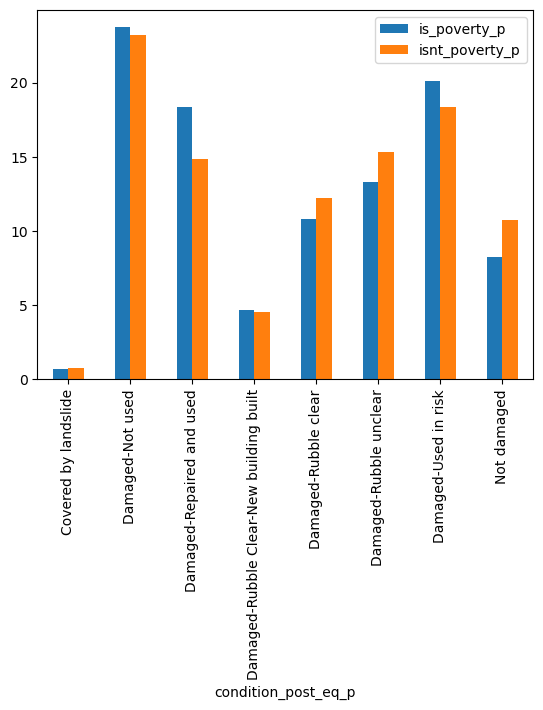

In [9]:
# Condition of building after earthquake by household, poverty (female head of household) - perturbed
condition_post_eq_f_p = histogram(households[households['gender_household_head_p'] == 'Female'], 'condition_post_eq_p', 'poverty_p')
histogram_plot(condition_post_eq_f_p, 'poverty_p')
condition_post_eq_f_p

,is_poverty_count,is_poverty,isnt_poverty_count,isnt_poverty
technical_solution_proposed,,,,
Major repair,25428,19.319106,99915,16.233065
Minor repair,19157,14.554668,87629,14.236974
No need,7049,5.355528,40003,6.499237
Reconstruction,79987,60.770698,387956,63.030724


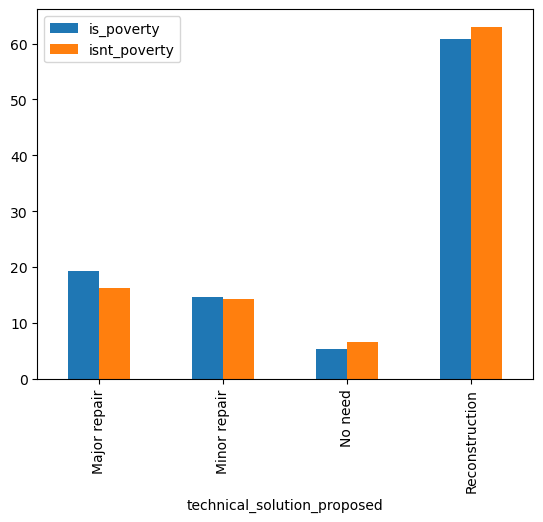

In [10]:
# Proposed repairs by household, poverty
technical_solution = histogram(households, 'technical_solution_proposed', 'poverty')
histogram_plot(technical_solution, 'poverty')
technical_solution

,is_poverty_p_count,is_poverty_p,isnt_poverty_p_count,isnt_poverty_p
technical_solution_proposed_p,,,,
Major repair,28642,19.181110,100916,16.881231
Minor repair,22700,15.201843,89331,14.943292
No need,10168,6.809354,46243,7.735530
Reconstruction,87814,58.807693,361310,60.439946


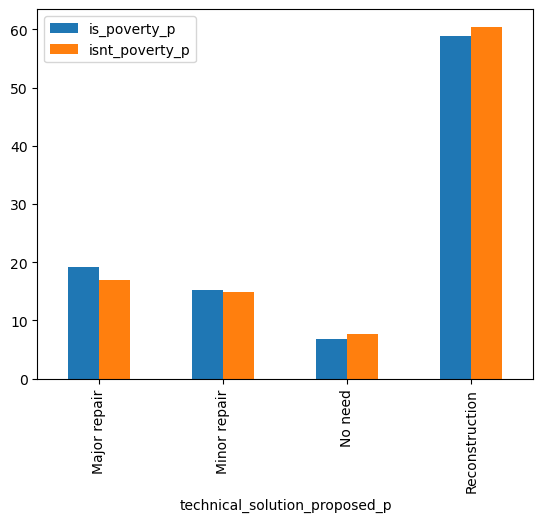

In [11]:
# Proposed repairs by household, poverty - perturbed
technical_solution_p = histogram(households, 'technical_solution_proposed_p', 'poverty_p')
histogram_plot(technical_solution_p, 'poverty_p')
technical_solution_p

,is_poverty_count,is_poverty,isnt_poverty_count,isnt_poverty
technical_solution_proposed,,,,
Major repair,6315,21.147277,35429,16.909361
Minor repair,5255,17.597616,36837,17.581363
No need,2159,7.229924,18633,8.893057
Reconstruction,16133,54.025183,118624,56.616219


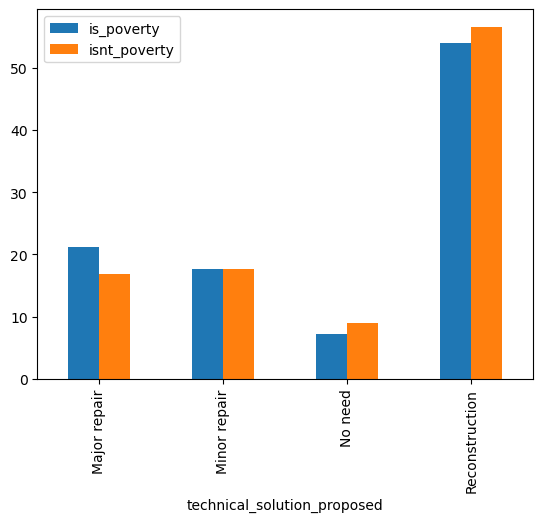

In [12]:
# Proposed repairs by household, poverty (female head of household)
technical_solution_f = histogram(households[households['gender_household_head'] == 'Female'], 'technical_solution_proposed', 'poverty')
histogram_plot(technical_solution_f, 'poverty')
technical_solution_f

,is_poverty_p_count,is_poverty_p,isnt_poverty_p_count,isnt_poverty_p
technical_solution_proposed_p,,,,
Major repair,8220,20.399553,36949,17.397016
Minor repair,7042,17.476114,37354,17.587705
No need,3350,8.313687,20445,9.626295
Reconstruction,21683,53.810646,117639,55.388983


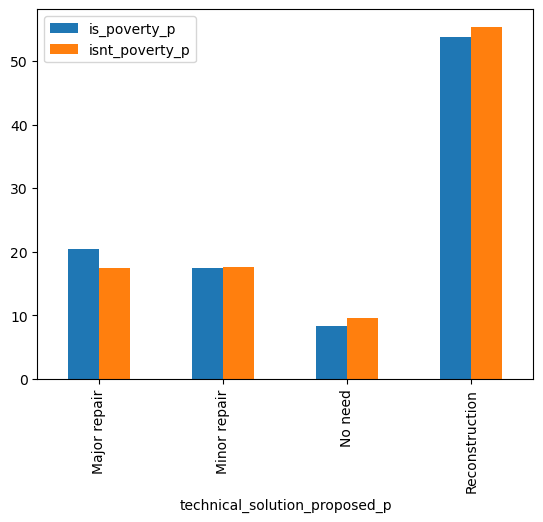

In [13]:
# Proposed repairs by household, poverty (female head of household) - perturbed
technical_solution_f_p = histogram(households[households['gender_household_head_p'] == 'Female'], 'technical_solution_proposed_p', 'poverty_p')
histogram_plot(technical_solution_f_p, 'poverty_p')
technical_solution_f_p

,is_female_headed_count,is_female_headed,isnt_female_headed_count,isnt_female_headed
condition_post_eq,,,,
Covered by landslide,89,0.037178,243,0.047858
Damaged-Not used,56561,23.627530,137318,27.044358
Damaged-Repaired and used,37821,15.799170,69175,13.623804
Damaged-Rubble Clear-New building built,9603,4.011513,23256,4.580198
Damaged-Rubble clear,27918,11.662336,74970,14.765111
Damaged-Rubble unclear,35384,14.781148,90444,17.812668
Damaged-Used in risk,46371,19.370807,81571,16.065158
Not damaged,25639,10.710317,30774,6.060845


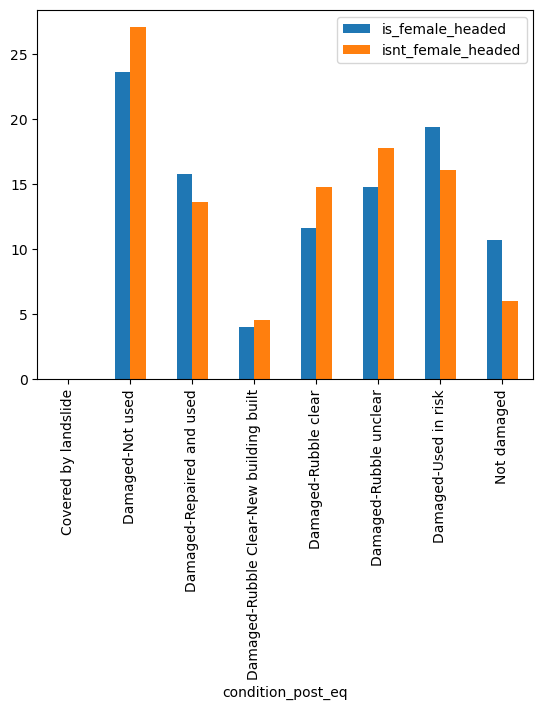

In [14]:
# Condition after the earthquake by household (female head of household)
condition_post_eq_with_f = histogram(households, 'condition_post_eq', 'female_headed')
histogram_plot(condition_post_eq_with_f, 'female_headed')
condition_post_eq_with_f

,is_female_headed_p_count,is_female_headed_p,isnt_female_headed_p_count,isnt_female_headed_p
condition_post_eq_p,,,,
Covered by landslide,1901,0.752317,3696,0.747496
Damaged-Not used,58868,23.296898,129113,26.112395
Damaged-Repaired and used,38922,15.403307,67375,13.626224
Damaged-Rubble Clear-New building built,11549,4.570495,24861,5.028001
Damaged-Rubble clear,30268,11.978503,72054,14.572526
Damaged-Rubble unclear,37858,14.982231,86110,17.415275
Damaged-Used in risk,47130,18.651607,78795,15.935856
Not damaged,26190,10.364642,32447,6.562228


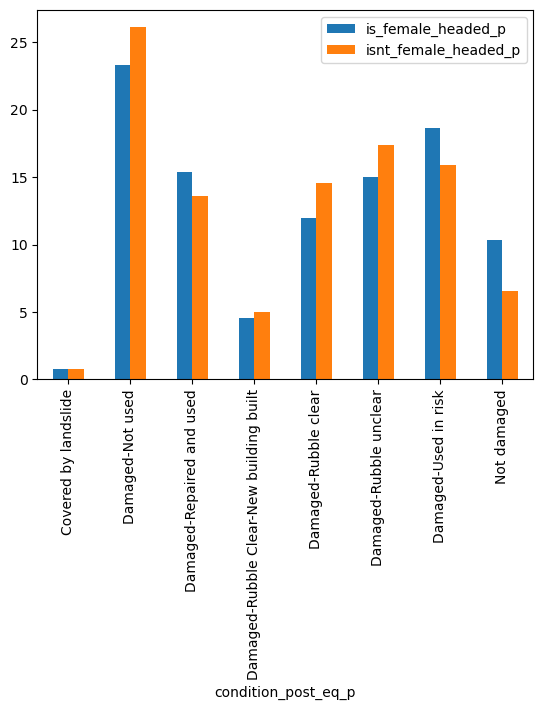

In [15]:
# Condition after the earthquake by household (female head of household) - perturbed
condition_post_eq_with_f_p = histogram(households, 'condition_post_eq_p', 'female_headed_p')
histogram_plot(condition_post_eq_with_f_p, 'female_headed_p')
condition_post_eq_with_f_p

<AxesSubplot: xlabel='condition_post_eq'>

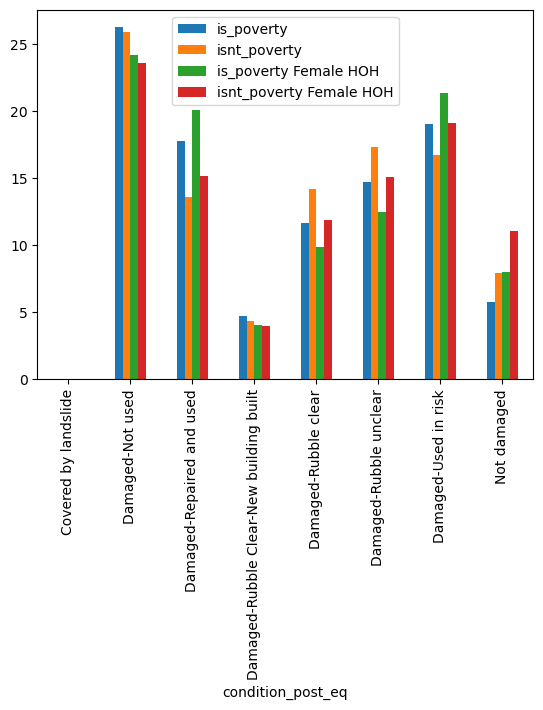

In [16]:
# Condition after the earthquake by household, poverty (female head of household)
condition_post_eq_with_f = condition_post_eq.join(condition_post_eq_f, rsuffix=' Female HOH')
condition_post_eq_with_f.plot.bar(y=['is_poverty', 'isnt_poverty', 'is_poverty Female HOH', 'isnt_poverty Female HOH'])


<AxesSubplot: xlabel='condition_post_eq_p'>

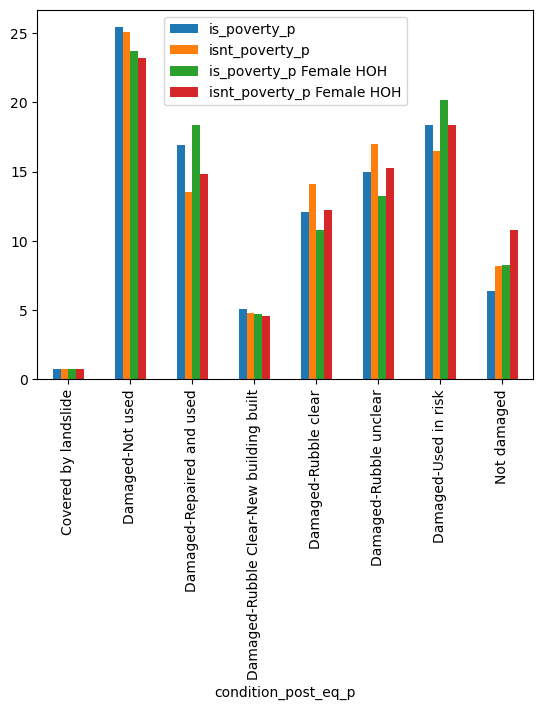

In [17]:
# Condition after the earthquake by household, poverty (female head of household) - perturbed
condition_post_eq_with_f_p = condition_post_eq_p.join(condition_post_eq_f_p, rsuffix=' Female HOH')
condition_post_eq_with_f_p.plot.bar(y=['is_poverty_p', 'isnt_poverty_p', 'is_poverty_p Female HOH', 'isnt_poverty_p Female HOH'])


In [18]:
# Load and clean geo data
geojson = gpd.read_file('./municipality.geojson')
ward_vdcmun_district_name_mapping = pd.read_csv('./ward_vdcmun_district_name_mapping.csv')
ward_vdcmun_district_name_mapping['vdc'] = ward_vdcmun_district_name_mapping['vdcmun_name'].str.replace('Rural Municipality', '')
ward_vdcmun_district_name_mapping['vdc'] = ward_vdcmun_district_name_mapping['vdc'].str.replace('Municipality', '')
ward_vdcmun_district_name_mapping['vdc'] = ward_vdcmun_district_name_mapping['vdc'].str.replace('Sub-Metropolitan City', '')
ward_vdcmun_district_name_mapping['vdc'] = ward_vdcmun_district_name_mapping['vdc'].str.strip()

In [19]:
vdcs = ward_vdcmun_district_name_mapping[['vdcmun_id', 'vdc', 'district_id', 'district_name']].drop_duplicates()
geojson = geojson.merge(vdcs, how='left', left_on='GaPa_NaPa', right_on='vdc')

<AxesSubplot: >

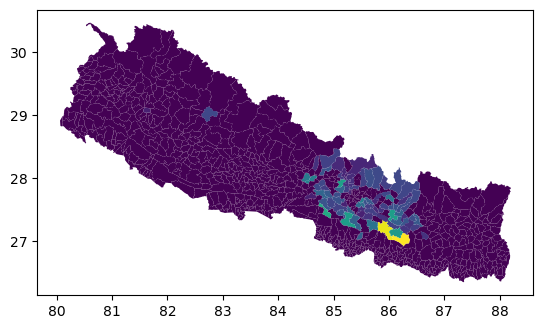

In [20]:
# Choropleth of new construction
new_construction_for_vdc = buildings[buildings['new_construction']].groupby('vdcmun_id').size().to_frame().reset_index()
new_construction_for_vdc.rename(columns={0:'new_construction'}, inplace=True)

geojson = geojson.merge(new_construction_for_vdc[['vdcmun_id', 'new_construction']].drop_duplicates(), how='left', on="vdcmun_id")
geojson['new_construction'] = geojson['new_construction'].fillna(0)
geojson.plot(column='new_construction')


<AxesSubplot: >

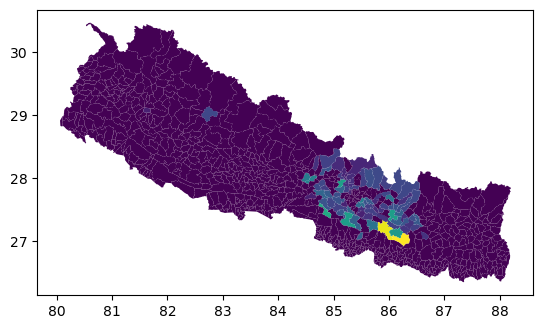

In [21]:
# Choropleth of new construction - perturbed
new_construction_for_vdc_p = buildings[buildings['new_construction_p']].groupby('vdcmun_id').size().to_frame().reset_index()
new_construction_for_vdc_p.rename(columns={0:'new_construction_p'}, inplace=True)

geojson = geojson.merge(new_construction_for_vdc_p[['vdcmun_id', 'new_construction_p']].drop_duplicates(), how='left', on="vdcmun_id")
geojson['new_construction_p'] = geojson['new_construction_p'].fillna(0)
geojson.plot(column='new_construction_p')


<AxesSubplot: >

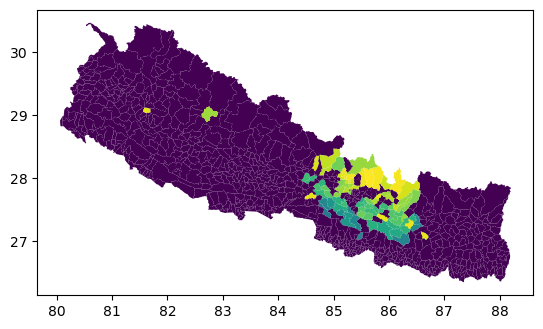

In [22]:
# Choropleth of intensity of earthquake damage
damage_for_vdc = buildings.groupby(['vdcmun_id'])['damage_grade_numeric'].mean().to_frame().reset_index()
# damage_for_vdc.rename(columns={0:'damage'}, inplace=True)

geojson = geojson.merge(damage_for_vdc[['vdcmun_id', 'damage_grade_numeric']].drop_duplicates(), how='left', on="vdcmun_id")
geojson['damage_grade_numeric'] = geojson['damage_grade_numeric'].fillna(0)
geojson.plot(column='damage_grade_numeric')

<AxesSubplot: >

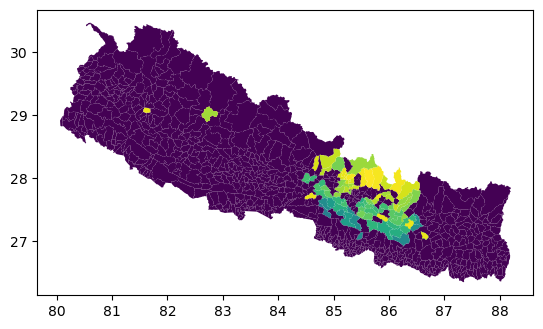

In [23]:
# Choropleth of intensity of earthquake damage - perturbed
damage_for_vdc_p = buildings.groupby(['vdcmun_id'])['damage_grade_numeric_p'].mean().to_frame().reset_index()
# damage_for_vdc.rename(columns={0:'damage'}, inplace=True)

geojson = geojson.merge(damage_for_vdc_p[['vdcmun_id', 'damage_grade_numeric_p']].drop_duplicates(), how='left', on="vdcmun_id")
geojson['damage_grade_numeric_p'] = geojson['damage_grade_numeric_p'].fillna(0)
geojson.plot(column='damage_grade_numeric_p')

<AxesSubplot: >

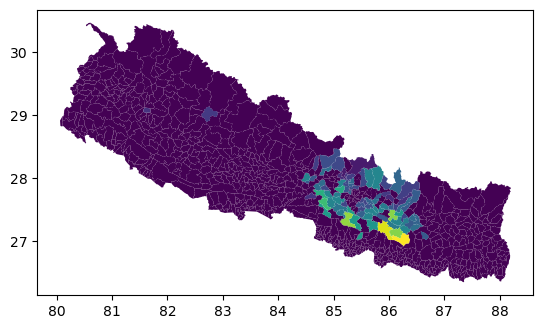

In [24]:
# Choropleth of prevalence of poverty
poverty_by_vdc = households[households['poverty']].groupby(['vdcmun_id_x'])['poverty'].size().to_frame().reset_index()
geojson = geojson.merge(poverty_by_vdc, how='left', left_on='vdcmun_id', right_on='vdcmun_id_x')
geojson['poverty'] = geojson['poverty'].fillna(0)
geojson.plot(column='poverty')


<AxesSubplot: >

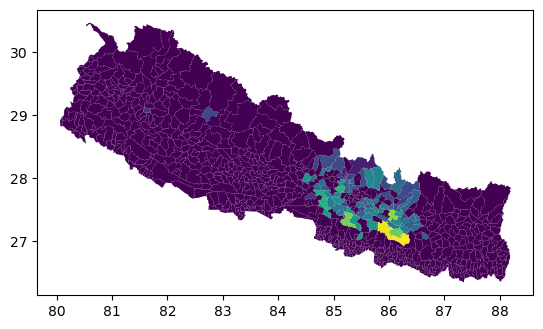

In [25]:
# Choropleth of prevalence of poverty - perturbed
poverty_by_vdc_p = households[households['poverty_p']].groupby(['vdcmun_id_x'])['poverty_p'].size().to_frame().reset_index()
geojson = geojson.merge(poverty_by_vdc_p, how='left', left_on='vdcmun_id', right_on='vdcmun_id_x')
geojson['poverty_p'] = geojson['poverty_p'].fillna(0)
geojson.plot(column='poverty_p')
